### General descriptive analysis on the original graph and the projected one

In [4]:
from scipy.stats import pareto
import networkx as nx
from load.helpers import parse_yaml
from graph.plotting import plot_graph_features, plot_asset_value_dist, plot_sector_network_info
from graph.create import create_original_graph, remove_financials_not_in_source, remove_edges_within_sectors
from graph.describe import create_descriptive_table, analyze_sectors
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

config_dict = parse_yaml("config.yaml")

In [2]:
G = create_original_graph(config_dict["data"]["edgelist_path"], config_dict["data"]["node_path"], config_dict["lists"]['wrong_nodes'])
H = remove_edges_within_sectors(G, is_financial=True)
I = remove_edges_within_sectors(H, is_financial=False)

In [2]:
g = nx.read_gexf(config_dict["graph"]["graph_path"])

In [3]:
# necessary conversion due to wrong data input. TODO correct data in original graph
for node in g.nodes():
    g.nodes[node]['equity'] /= 1000
    g.nodes[node]['liabilities'] /= 1000

#### Degree distribution

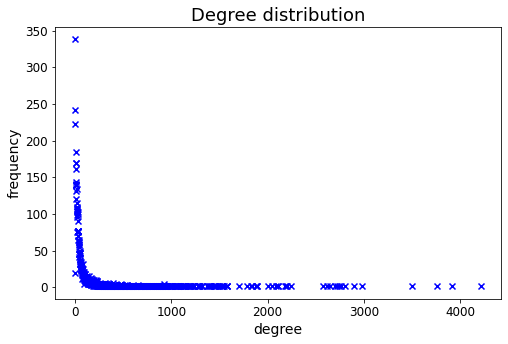

In [4]:
orig_dist = plot_graph_features(H, loglog=False)

From the degree distribution we can suspect a power law distribution. To get a better understanding, we check it on a log-log scale as well.

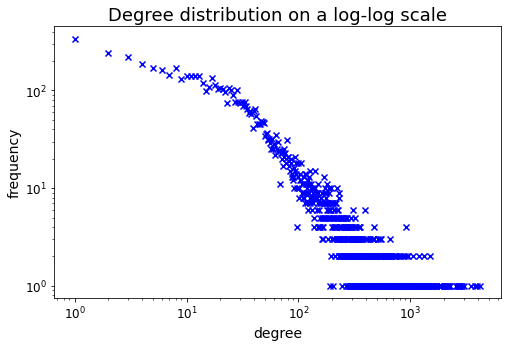

In [5]:
orig_dist_log = plot_graph_features(H, loglog=True)

We can see that the original graph's degree distributon almost fits to a linear line, but there is a turning point in the steepness of the linear line. We can say it almost follows a distribution close to a power law distribution, meaning it is a scale-free newtowk. 

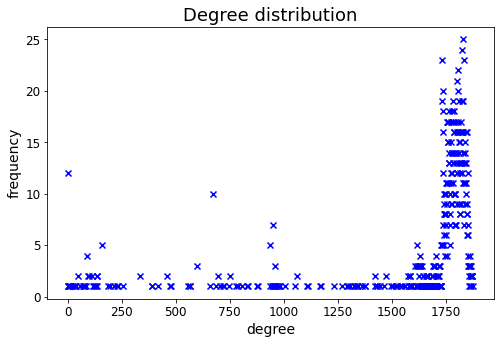

In [6]:
projected_dist = plot_graph_features(g, loglog=False)

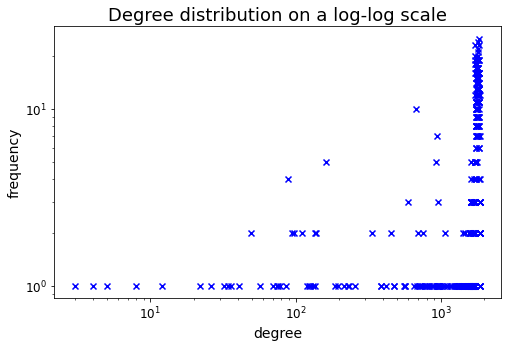

In [7]:
projected_dist_log = plot_graph_features(g, loglog=True)

The projected graph's degree distribution follows no known distribution, but that is normal after the projection. We can see that many nodes have more than a thousand edges, which means that most of the companies are held by several entitites.

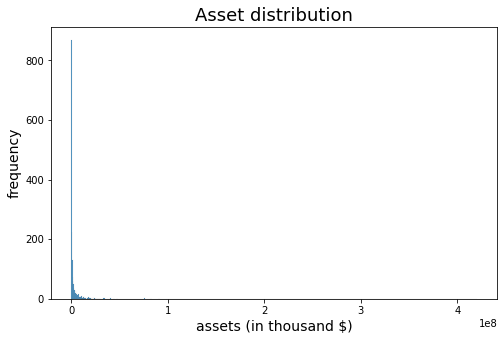

In [20]:
asset_dist = plot_asset_value_dist(g)

Asset distribution shows power law distribution with some extreme outliers.

#### Diameter, connectedness, components, clustering coefficient

In [8]:
descriptive_table = create_descriptive_table([H, g])
descriptive_table.to_csv(config_dict['outputs']['descriptive_table'], index=False)
descriptive_table

,nodes,edges,is_directed,is_connected,largest_comp_frac,diameter_of_largest_cc,clustering_coefficient
name,,,,,,,
original,7957,395721,True,False,0.002891,5,0.007245
projected,1901,1600903,False,False,0.993688,3,0.964096


The projected graph has a clustering coefficient close to one, that means almost all possible edges are drawn in the graph. The reason is in the projection method where every two nodes are connected if there is at least one entity that has ownership in both of the firms.

On the other hand we can see that the largest component is almost the whole network in the projected version, making it optimal to work with. 

We can also see that the diameter is only 3, meaning the two furthest points in the graph can be reached in three steps.

With the projection we lost around 6 thousand firms but they were all financial entities, most of them are not even traded publicly. We kept the largest 1900 firms from all the other sectors on the market (based on asset size).

The projected graph is also undirected, makint it easier to work with.

#### Sector analysis on the projected graph

In [5]:
sector_analysis = analyze_sectors(g, config_dict['lists']['sectors'])
sector_analysis.to_csv(config_dict['outputs']['sector_analysis'], index=False)

In [23]:
sector_analysis.sort_values("total_sector_size", ascending=False)

,nodes,total_sector_size,rel_sector_size,clustering_coefficient,edge_ratio,equity_level
sector,,,,,,
Information Technology,415,2.513528e+09,0.217027,0.979239,0.905091,0.530571
Health Care,668,1.920807e+09,0.165849,0.972419,0.894327,0.663703
Consumer Discretionary,216,1.662360e+09,0.143534,0.967307,0.908431,0.442281
Industrials,243,1.408896e+09,0.121649,0.964502,0.901605,0.481157
Communication Services,111,1.103980e+09,0.095322,0.965951,0.896123,0.503285
Consumer Staples,60,7.858701e+08,0.067855,0.929230,0.874385,0.449358
Materials,71,6.723184e+08,0.058050,0.954595,0.894451,0.381397
Utilities,22,6.497101e+08,0.056098,0.920547,0.829819,0.314330
Energy,47,5.678161e+08,0.049027,0.970200,0.899404,0.509950


From the above table we can see that the largest sectors (based on asset value) have the most companies in them, except the IT, where less nodes still result in the most cummulated asset value.

We can see that the clustering coefficient varies around 95%, meaning almost all edges are present in the sectors.

The edge ratio represents the ratio between the edges coming from one sector towards all the other sectors divided by the total possible edges from the sector to the others. The value shows how connected is one sector to the rest of the graph. The most connected is the real estate sector and the least connected is the utilities sector.

The equity level shows what average percentage of equity a given sector has compared to the total assets. The sector with the highest equity level is the health care and the lowest is the utilities with the others ranging between 30% and 67%.

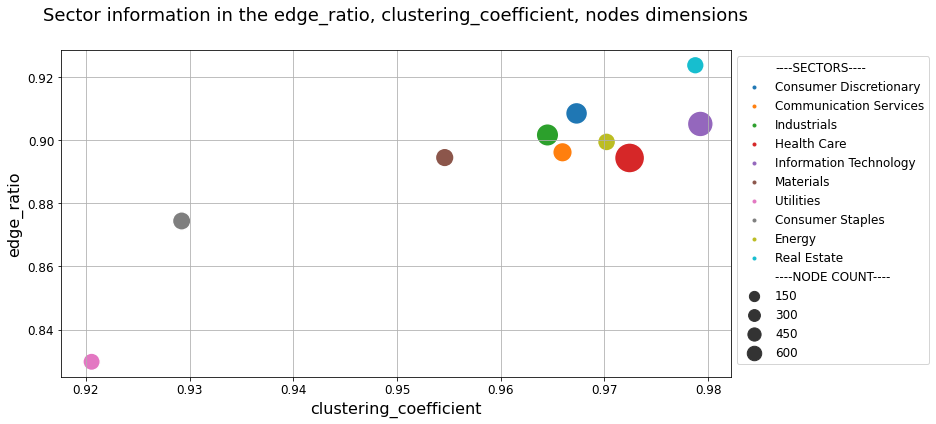

In [71]:
fig = plot_sector_network_info(sector_analysis, "clustering_coefficient", "edge_ratio", "nodes")

From this graph we can see that there is no straighforward connection between the sector size and the clustering coefficent, nor the edge ratio.

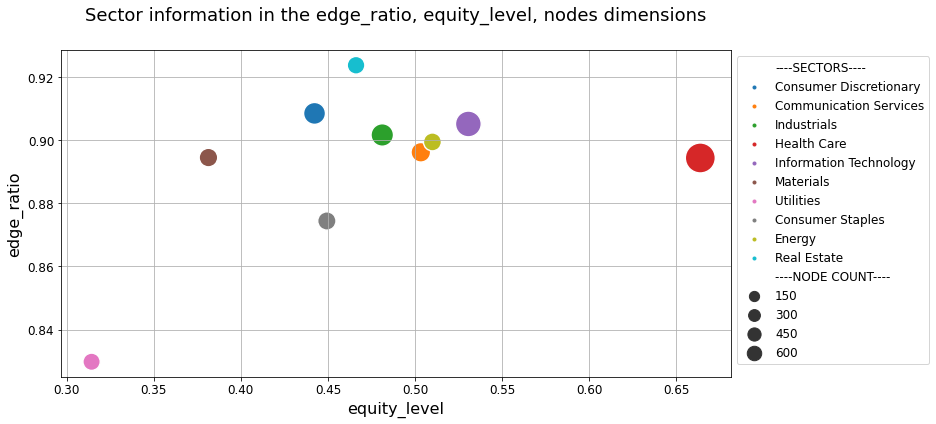

In [72]:
fig = plot_sector_network_info(sector_analysis, "equity_level", "edge_ratio", "nodes")

We can see that the largest equity level belongs to the health care sector, with a relatively moderate edge ratio. 

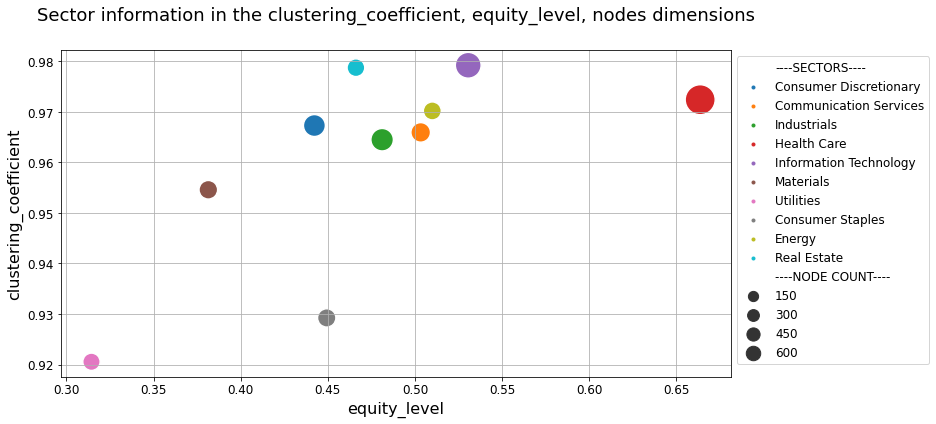

In [73]:
fig = plot_sector_network_info(sector_analysis, "equity_level", "clustering_coefficient", "nodes")

On the three charts we can see the negative outlier sector, the Utilities, where  the clustering coefficient, the edge ratio and the equity level is also the lowest. On the other hand, Health Care sector is on the right hand side of the charts for equity level and clustering coefficient as well, with relatively low edge ratio. The latter two means the sector itself is really connected, but compared to the other sectors it is not that embedded in the network.